In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR * 5)
overlap = int(SR)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db = '../../../../../data/FSDKaggle2018/'
dataset = pd.read_csv(path_to_db + 'meta/train.csv')
dataset = dataset.drop(['manually_verified', 'freesound_id', 'license'], axis=1)
ps = Audio_Processor(path_to_db + 'train/')
classes = dataset.label.unique()
h_classes = ['Human & Animal', 'Interacting Materials', 'Musical Instruments']
mapping = {'Hi-hat': h_classes[2],
           'Saxophone': h_classes[2],
           'Trumpet': h_classes[2],
           'Glockenspiel': h_classes[2],
           'Cello': h_classes[2],
           'Knock': h_classes[1],
           'Gunshot_or_gunfire': h_classes[1],
           'Clarinet': h_classes[2],
           'Computer_keyboard': h_classes[1],
           'Keys_jangling': h_classes[1],
           'Snare_drum': h_classes[2],
           'Writing': h_classes[1],
           'Laughter': h_classes[0],
           'Tearing': h_classes[1],
           'Fart': h_classes[1],
           'Oboe': h_classes[2],
           'Flute': h_classes[2],
           'Cough': h_classes[0],
           'Telephone': h_classes[1],
           'Bark': h_classes[0],
           'Chime': h_classes[2],
           'Bass_drum': h_classes[2],
           'Bus': h_classes[1],
           'Squeak': h_classes[0],
           'Scissors': h_classes[1],
           'Harmonica': h_classes[2],
           'Gong': h_classes[2],
           'Microwave_oven': h_classes[1],
           'Burping_or_eructation': h_classes[0],
           'Double_bass': h_classes[2],
           'Shatter': h_classes[1],
           'Fireworks': h_classes[1],
           'Tambourine': h_classes[2],
           'Cowbell': h_classes[2],
           'Electric_piano': h_classes[2],
           'Meow': h_classes[0],
           'Drawer_open_or_close': h_classes[1],
           'Applause': h_classes[1],
           'Acoustic_guitar': h_classes[2],
           'Violin_or_fiddle': h_classes[2],
           'Finger_snapping': h_classes[1]
           }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    row['target'] = np.where(classes == row['label'])
    dataset.loc[index, 'h_target'] = mapping[row['label']]
dataset.columns = ['filename', 'target', 'h_target']
enum_map = enumerate_strings(dataset, ['filename'])

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=10,
                        random_state=42
                       )

In [6]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,9473.000000,...,9.473000e+03,9.473000e+03,9473.000000,9473.000000,9473.000000,9.473000e+03,9473.000000,9473.000000,9473.000000,9473.000000
mean,36.226862,22.175812,16.897902,14.440823,12.588374,12.210067,11.903620,11.866944,11.721354,11.542368,...,-2.610257e-02,-2.695195e-02,32.676472,54.195531,13.265712,4.492206e+10,2.797787,1.356804,20.385728,5.498892
std,27.659926,15.255412,12.704856,11.167013,10.519583,10.609160,10.886349,11.315877,11.392690,11.337392,...,3.224256e-02,3.122700e-02,47.200469,72.879911,36.484102,4.372235e+12,4.751559,0.731472,12.262045,2.872690
min,0.083888,0.055048,0.047802,0.017948,0.060122,0.043417,0.028229,0.034331,0.027488,0.017618,...,-1.656505e-01,-1.713837e-01,5.653630,9.253118,1.258367,7.359906e+00,0.159334,0.000000,0.000000,1.000000
25%,17.340015,11.866179,9.063716,8.086071,6.795067,6.510878,6.154096,5.955297,5.815221,5.676948,...,-4.661091e-02,-4.733724e-02,17.328147,30.036761,5.613739,2.540516e+01,0.595488,1.000000,10.000000,3.000000
50%,26.814388,16.871618,12.029670,10.359869,9.024661,8.796802,8.506577,8.213115,8.007669,7.789436,...,-2.256751e-02,-2.395691e-02,26.720073,42.935405,9.715109,3.858725e+01,1.122713,2.000000,20.000000,5.000000
75%,47.806771,28.968695,20.746010,16.361833,13.046859,12.169184,11.331381,10.884903,10.592758,10.281859,...,-6.031138e-10,-8.266739e-10,37.137182,58.471814,14.364623,5.782954e+01,2.993144,2.000000,32.000000,8.000000
max,171.680443,112.133024,137.632017,85.966195,77.440500,77.952964,82.252132,88.344674,92.847622,90.165006,...,1.783609e-01,8.931179e-02,2832.300385,3207.026175,2711.557445,4.255467e+14,97.860104,2.000000,40.000000,10.000000


In [7]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

# Training

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
feat_red = PCA(n_components=30)
feat_red.fit(train_X,y=train_y)
train_X = feat_red.transform(train_X)

params = {
          'n_neighbors': range(5,25,1),
          'algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

knn = KNN(n_neighbors=15, algorithm='ball_tree')

clf = GridSearchCV(knn, params, cv=5)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'algorithm': ('ball_tree', 'kd_tree', 'brute'), 'n_neighbors': range(5, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_algorithm',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.6240469208211143
Confusion matrix, without normalization
[[ 65 115  73]
 [ 75 340 170]
 [ 39 169 659]]


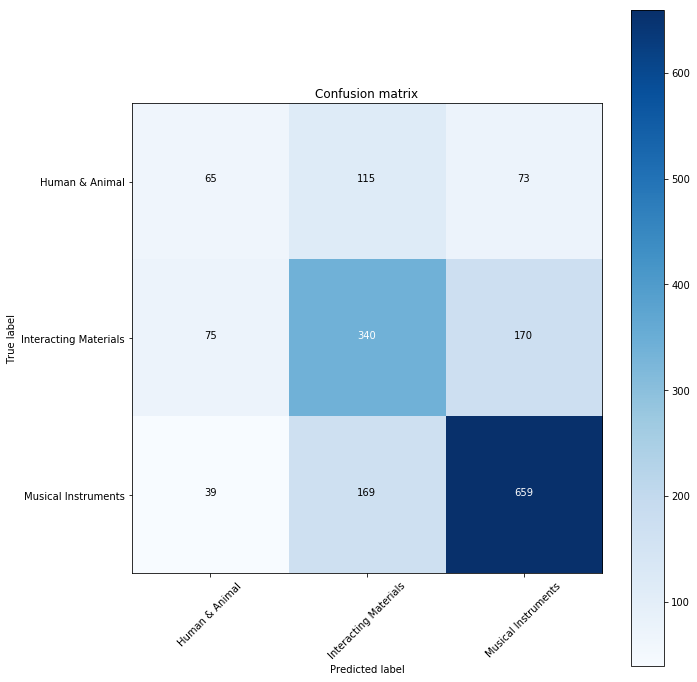

In [11]:
test_X = scaler.transform(test_X)
test_X = feat_red.transform(test_X)
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [12]:
all_df = df[df.fold == 1]

In [13]:
all_df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
3,43.321039,29.359653,37.969028,22.064697,23.307143,39.468864,28.904546,22.033128,28.957273,22.249699,...,-0.039391,-0.016291,20.434650,39.174187,3.207934,35.236851,1.513151,2,19,1
10,9.238724,9.215207,9.119908,9.125605,9.074720,9.057060,9.010377,8.965163,8.886466,8.847235,...,-0.076417,-0.077361,48.083852,75.308697,31.079183,88.907231,0.952869,2,23,1
14,40.061048,16.309936,8.178150,6.421196,6.796470,5.096424,4.517546,4.607614,4.921549,5.159280,...,-0.018291,-0.055445,38.016273,86.999482,12.158918,168.819280,22.679536,2,6,1
19,34.280387,21.456141,14.292751,11.803294,8.362315,8.177938,7.315553,7.093404,6.593251,6.030128,...,-0.019644,-0.035826,22.984738,31.824832,9.053585,27.635969,0.777744,0,26,1
29,82.111233,57.458399,41.840477,39.548232,40.858231,41.705750,34.950270,37.954218,33.264300,39.943352,...,0.004942,-0.016879,11.672951,20.483245,3.892225,18.516599,5.228198,2,7,1


In [14]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['h_target']
X = scaler.transform(X)
X = feat_red.transform(X)

0.6592827004219409
Confusion matrix, without normalization
[[ 45  55  35]
 [ 33 213  90]
 [ 16  94 367]]


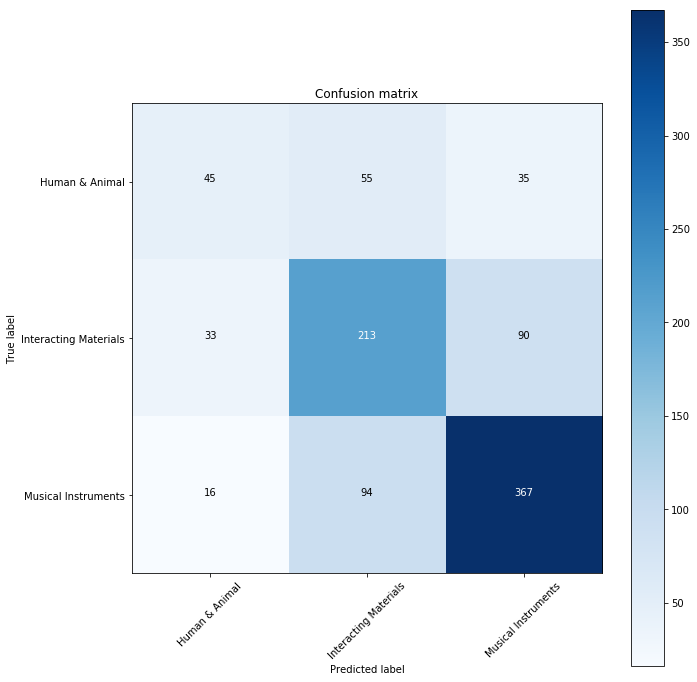

In [15]:
pred = clf.predict(X)
pred_prob = clf.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [16]:
clf.best_estimator_ 

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=24, p=2,
           weights='uniform')

In [17]:
import seaborn as sns
misclassified = {
    'Actual h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': [],
    'Music_prob': []
}
for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Actual h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
        misclassified['Music_prob'].append(prob[2])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,Actual h_target,Actual target,Anim_prob,Interact_prob,Music_prob
0,Interacting Materials,Gong,0.333333,0.541667,0.125000
1,Interacting Materials,Clarinet,0.125000,0.500000,0.375000
2,Human & Animal,Knock,0.500000,0.333333,0.166667
3,Interacting Materials,Squeak,0.125000,0.708333,0.166667
4,Musical Instruments,Cough,0.166667,0.375000,0.458333


In [18]:
average_prob = misclassified.groupby('Actual h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob,Music_prob
Actual h_target,,,
Human & Animal,0.460034,0.318027,0.221939
Interacting Materials,0.192673,0.556488,0.250839
Musical Instruments,0.154000,0.265667,0.580333


In [19]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob,Music_prob
Actual target,,,
Acoustic_guitar,0.263889,0.461111,0.275000
Applause,0.107143,0.214286,0.678571
Bass_drum,0.180556,0.263889,0.555556
Burping_or_eructation,0.263889,0.340278,0.395833
Bus,0.166667,0.550000,0.283333
Cello,0.213542,0.424479,0.361979
Chime,0.243590,0.509615,0.246795
Clarinet,0.125000,0.593750,0.281250
Computer_keyboard,0.041667,0.583333,0.375000


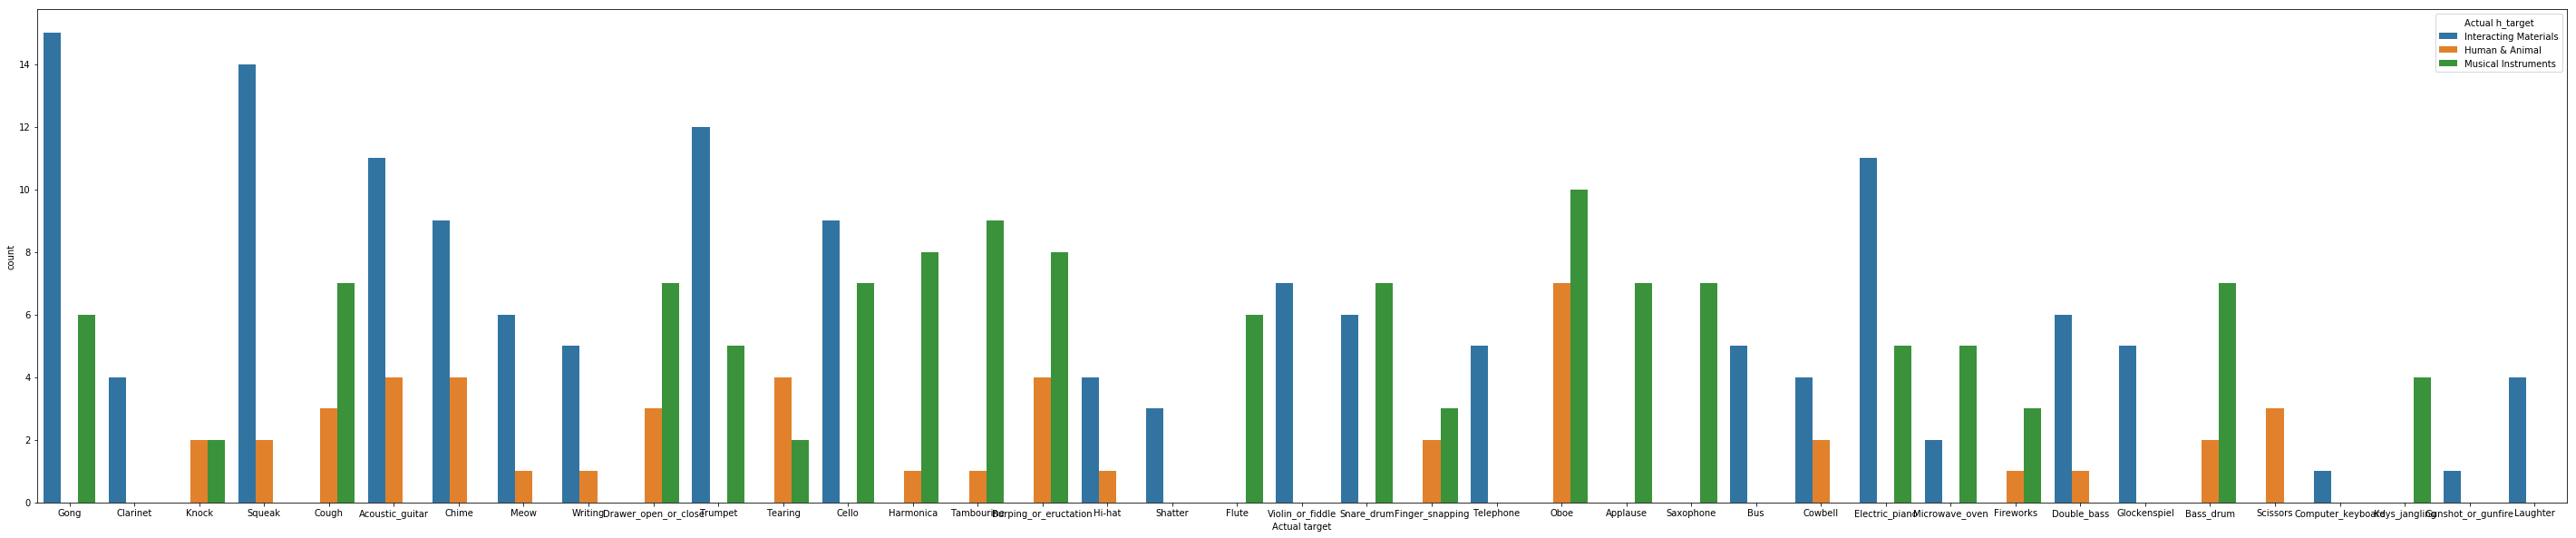

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Actual h_target',data=misclassified)